## Exploring Protein Language models

In this assignment you will walk through the following tasks:

- Introduction to ESM-2
- Load lysozyme sequence + PDB (1REX) and compute per-residue embeddings at multiple layers
- Find the ESM-2 layer that best predicts contacts (AUC) and correlates with absolute distances
- Compute pseudo-likelihood per residue and use to score variants

This file is intended to be run in the mamba environment described in the assignment.

This is designed to be completable in about 4 hours. The notebook, can easily run on CPU and GPU, but avoid using Apple Silicon accelerators as they are no longer supported in pytorch and may lead to unpredictable output.

I recommend you make use of the educational compute resource to minimize the trouble of setting things up locally as we cannot provide support for this. Please check the page https://git.chalmers.se/karppa/minerva on how to get access.

The assignment has a total of 10 points, 6 are needed to pass. Each part is annotated with the points given, each part is split in to a number of tasks, which are either writing task (annotated with w) and or coding tasks (annotated with c) -- Be sure to use code cells for coding tasks and Markdown cells for writing tasks.

**Several downloads happens in the first setup cell, a total around 100 MB, so be sure to be connected to the internet, or run this on a cloud service, such as minerva.**


In [1]:
# This is a setup cell, it will provide a number of convenience functions and download data for the assignment.
import os
import sys
import math
import gzip
import urllib
import tempfile
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from Bio.PDB import PDBParser
from Bio import SeqIO
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import roc_auc_score

import torch
import esm

# Check if GPU is available.
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


def load_pdb_ca_coords(pdb_path, chain_id="A"):
    """Return list of CA coordinates for residues in chain (ordered by residue) and corresponding residue ids."""
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("X", pdb_path)
    model = structure[0]
    chain = model[chain_id]
    coords = []
    res_ids = []
    residues = []
    for res in chain:
        if "CA" in res:
            coords.append(res["CA"].coord)
            res_ids.append(res.get_id())
            residues.append(res)
    coords = np.array(coords)
    return coords, res_ids, residues


def pairwise_metrics(embeddings):
    """Given embeddings (L x D) compute cosine similarity and euclidean distance matrices."""
    emb = embeddings
    norms = np.linalg.norm(emb, axis=1, keepdims=True)
    safe = norms.copy()
    safe[safe == 0] = 1.0
    emb_n = emb / safe
    cos_sim = emb_n @ emb_n.T
    euc = squareform(pdist(emb, metric="euclidean"))
    return cos_sim, euc


def flatten_upper(mat):
    idx = np.triu_indices_from(mat, k=1)
    return mat[idx], idx


PDB_ID = "1REX"
PDB_FILE = f"{PDB_ID}.pdb"
urllib.request.urlretrieve(f"http://files.rcsb.org/download/{PDB_FILE}", PDB_FILE)

if not os.path.exists(PDB_FILE):
    print(
        f"PDB file {PDB_FILE} not found in working directory. Please download it (e.g. from https://www.rcsb.org) and place it here."
    )


MODEL_NAME = "esm2_t12_35M_UR50D"  # this model is about a 30MB download
print("Loading model:", MODEL_NAME)

model, alphabet = esm.pretrained.load_model_and_alphabet(MODEL_NAME)
model = model.eval().to(DEVICE)
batch_converter = alphabet.get_batch_converter()

from Bio.PDB import Polypeptide
from Bio.Data import IUPACData

three_to_one = IUPACData.protein_letters_3to1
aa3to1 = lambda resname: three_to_one.get(resname.capitalize(), "X")

if os.path.exists(PDB_FILE):
    coords, res_ids, residues = load_pdb_ca_coords(PDB_FILE, chain_id="A")
    # extract sequence from residues
    seq = "".join(aa3to1(res.get_resname()) for res in residues)
    print("Sequence extracted from PDB (len={}):".format(len(seq)), seq)
else:
    print(f"Could not open {PDB_FILE}")


Device: cpu
Loading model: esm2_t12_35M_UR50D
Sequence extracted from PDB (len=130): KVFERCELARTLKRLGMDGYRGISLANWMCLAKWESGYNTRATNYNAGDRSTDYGIFQINSRYWCNDGKTPGAVNACHLSCSALLQDNIADAVACAKRVVRDPQGIRAWVAWRNRCQNRDVRQYVQGCGV


## Part 0: Computing ESM-2 embeddings from sequence (2 points)

In this part of the model you will get familiar with the input and output of the ESM model.

In the cell above, a tiny version of ESM-2 has been downloaded and instantiated into the Python object `model` -- you will work with this model to perform tasks in this assignment -- it functions much like other pre-trained `pytorch` models.

The `model` takes an input batch as first argument, and we will use two keyword arguments as well in this assignment `repr_layers` and `return_contacts`. The `repr_layers` takes a list of numbers indicating at what layer latent representations (embeddings) should be given. The `return_contacts` takes a boolean and should be `false` in this assignment, as it attempts to predict contacts.

The first argument is a batch of _tokens_, however, we have our data, the protein sequence of lysozyme, as a string: `seq`.

**Tasks:**

1. **w** Consult the [Official README.md](https://github.com/facebookresearch/esm/tree/main/README.md) to identify some basic facts about the pre-trained model that you will be using (Hint: look in the cell above for a model name for the model). Write important information such as the model size, number of layers and embedding dimension. Check if the `model.num_layers` attribute aligns with information. (0.5p)
2. **c** Use the `batch_converter` which has been generated in the cell above to covert the lysozyme sequence into some `batch_tokens` we can feed to the model. (Hint: Check the README.md file for example of how to prepare input and retrieve output ) (0.5p)
3. **c** Use the `model` to compute embeddings for all layers (hint: use `repr_layers` keyword argument to give list of layers you want output from, note that numbering starts from 1 not 0) (0.75p)
4. **w** Check the output -- what do you get? -- Do the dimensions of the outputs match your expectations and the information from the README? (0.25p)


In [2]:
seq

'KVFERCELARTLKRLGMDGYRGISLANWMCLAKWESGYNTRATNYNAGDRSTDYGIFQINSRYWCNDGKTPGAVNACHLSCSALLQDNIADAVACAKRVVRDPQGIRAWVAWRNRCQNRDVRQYVQGCGV'

#### 1. Identify facts in the README.

The number of layers according to the README is 12.
There should be around 35M parameters, and the embedding dimension is 480.
The model is based on the UR50/D 2021_04 dataset.


In [43]:
# 1. Verify model properties
print("Model layers:", model.num_layers)
print("Model embedding dimension:", model.embed_dim)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total model parameters: {total_params:.2E}")

print("=" * 40)

# 2. Tokenize lysozyme sequence into batch_tokens
data = [("lysozyme", seq)]
batch_labels, batch_strs, batch_tokens = batch_converter(data)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)
batch_tokens = batch_tokens.to(DEVICE)
print("Batch tokens shape:", batch_tokens.shape)
print("Batch lengths:", batch_lens)

print("=" * 40)

# 3. Pass batch_tokens through the model to get per-residue representations for all layers
with torch.no_grad():
    results = model(
        batch_tokens,
        repr_layers=list(range(1, model.num_layers + 1)),
        return_contacts=False,
    )
token_representations = results["representations"]
print("Number of layers in token representations:", len(token_representations))
print(
    "Shape of token representations for layer 1:",
    token_representations[1].shape,
)

Model layers: 12
Model embedding dimension: 480
Total model parameters: 3.35E+07
Batch tokens shape: torch.Size([1, 132])
Batch lengths: tensor([132])
Number of layers in token representations: 12
Shape of token representations for layer 1: torch.Size([1, 132, 480])


#### 4. Analyze the output

The batch size for the token_representation is 1 which is correct since we only passed in one sequence.
The length dimension matches the length of the lysozyme sequence plus 2 special tokens (start and end).
The embedding dimension matches the model's embedding dimension.


## Part 1: Comparing protein structure to ESM-2 embeddings correlations. (4.25 points)

In this part of the model you will compare the embedding you extracted above to the 3D protein structure, to evaluate whether the model could be used for structure prediction.

**Tasks:**

1. **c** Check whether the `coords` were loaded from the PDB-file. The variable should contain the 3D coordinates of all the alpha-carbons in lysozyme. Check the dimensions. Do they match your expectations? (0.5p)
2. **c** use `pdist` and `squareform` to compute distance matrices: square matrices where the index $(i,j)$ is the Euclidean distance between alpha carbon $i$ and $j$. The units will be in Aangström. Compute a contact matrix, where the index $(i,j)$ is 1 if two alpha carbons i and j are within 8 Aangström of each other and 0 otherwise. (hint: Consult [scipy docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html) to understand how to use the functions) (1.25p)
3. **c** For each of the embeddings computed above use the function given `pairwise_metrics` to compute euclidean differences and cosine similarities between all pairs of positions. Compute the `roc_auc_score` between the contact matrix computed above and all the embedding pair-representations. Compute pearson and spearman correlations between minus distances and embedding pair-representations. (Hint: walk through the functions and be sure you understand how things are computed and how to use the results) (1p)
4. **w** Use the information from task 3 to decide which one is best? justify your answer. Select the best and use it for the next tasks. (0.25p)
5. **c** Make the following plots: 1) scatter-plot of pairwise cosine similarity vs the minus pair-wise distances alpha carbon distances, 2) `imshow` alpha carbon-alpha carbon contact matrix side by side with 3) `imshow` of pairwise cosine similarities. When showing contacts and cosine-similarities set values in the matrix where the difference between index $i$ and $j$ is less than 5 to `np.nan` (0.5p)
6. **w** Discuss the results. Do you think the model use is good enough to predict 3D structure? Why? Why not? What would you try next if you wanted to predict structure? (0.75p)


In [ ]:
# 1. Check whether coords were loaded correctly from PDB and whether the dimensions match the sequence length
print("CA coordinates shape:", coords.shape)
print("Number of residues:", len(res_ids))
print("Sequence length:", len(seq))

CA coordinates shape: (130, 3)
Number of residues: 130
Sequence length: 130


This seems good, considering the shape represents 130 points in 3d space.


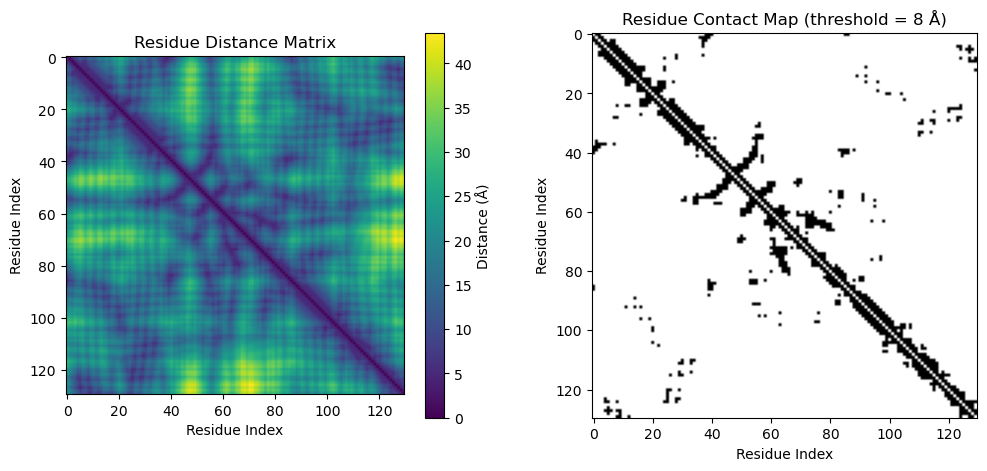

In [49]:
# 2. Compute distance matrices using pdist and squareform where (i, j) entry is the distance between residue i and j
dist_matrix = squareform(pdist(coords, metric="euclidean"))
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(dist_matrix, cmap="viridis")
plt.colorbar(label="Distance (Å)")
plt.title("Residue Distance Matrix")
plt.xlabel("Residue Index")
plt.ylabel("Residue Index")
contact_threshold = 8.0  # Angstroms
contact_matrix = (dist_matrix < contact_threshold).astype(int)
np.fill_diagonal(
    contact_matrix, 0
)  # remove self-contacts, not specified, but feels right
plt.subplot(1, 2, 2)
plt.imshow(contact_matrix, cmap="Greys")
plt.title("Residue Contact Map (threshold = 8 Å)")
plt.xlabel("Residue Index")
plt.ylabel("Residue Index")
plt.show()

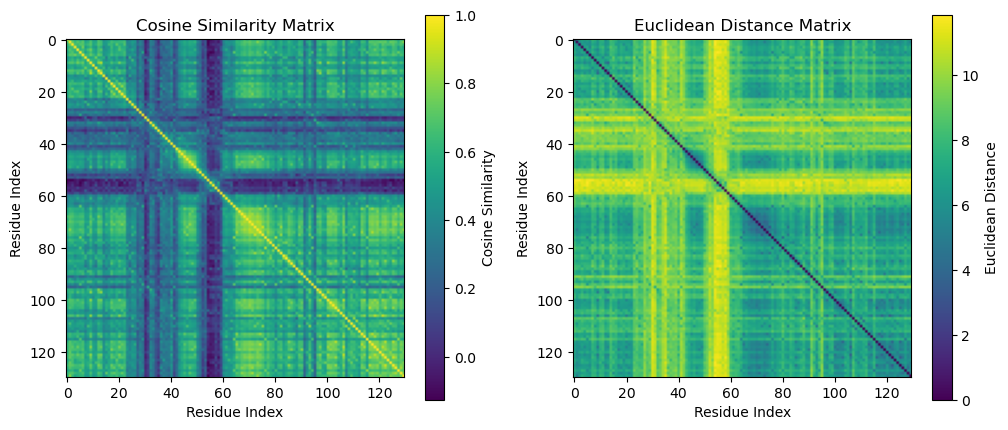

ROC-AUC for contact prediction using cosine similarity: 0.6167
ROC-AUC for contact prediction using euclidean distance: 0.6086
Pearson correlation between cosine similarity and -distance: -0.1836
Spearman correlation between cosine similarity and -distance: -0.1767
Pearson correlation between euclidean distance and -distance: 0.1891
Spearman correlation between euclidean distance and -distance: 0.1852


In [55]:
# 3. Use pairwise_metrics to compute cosine similarity and euclidean distance matrices between all pairs
embeddings_layer_12 = token_representations[12][0, 1 : batch_lens[0] - 1].cpu().numpy()
cos_sim, euc = pairwise_metrics(embeddings_layer_12)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(cos_sim, cmap="viridis")
plt.colorbar(label="Cosine Similarity")
plt.title("Cosine Similarity Matrix")
plt.xlabel("Residue Index")
plt.ylabel("Residue Index")
plt.subplot(1, 2, 2)
plt.imshow(euc, cmap="viridis")
plt.colorbar(label="Euclidean Distance")
plt.title("Euclidean Distance Matrix")
plt.xlabel("Residue Index")
plt.ylabel("Residue Index")
plt.show()

roc_auc_cos = roc_auc_score(flatten_upper(contact_matrix)[0], flatten_upper(cos_sim)[0])
print(f"ROC-AUC for contact prediction using cosine similarity: {roc_auc_cos:.4f}")
roc_auc_euc = roc_auc_score(flatten_upper(contact_matrix)[0], -flatten_upper(euc)[0])
print(f"ROC-AUC for contact prediction using euclidean distance: {roc_auc_euc:.4f}")

minus_dist_flat, _ = flatten_upper(-dist_matrix)

pearson_cos, _ = pearsonr(flatten_upper(cos_sim)[0], minus_dist_flat)
spearman_cos, _ = spearmanr(flatten_upper(cos_sim)[0], minus_dist_flat)
print(f"Pearson correlation between cosine similarity and -distance: {pearson_cos:.4f}")
print(
    f"Spearman correlation between cosine similarity and -distance: {spearman_cos:.4f}"
)

pearson_euc, _ = pearsonr(flatten_upper(euc)[0], minus_dist_flat)
spearman_euc, _ = spearmanr(flatten_upper(euc)[0], minus_dist_flat)
print(
    f"Pearson correlation between euclidean distance and -distance: {pearson_euc:.4f}"
)
print(
    f"Spearman correlation between euclidean distance and -distance: {spearman_euc:.4f}"
)

#### 4. Use the information from task 3 to determine the best embedding-pair representation matrix.

The cosine similarity matrix has better ROC-AUC score, which signifies it being better at classifying whether residues contact or not.
While the pearson/spearman correlations are better for the euclidian distance matrix, due to having correct signage, and indicating correlation rather than anti-correlation, this is not as important due to the low magnitude of the correlations.


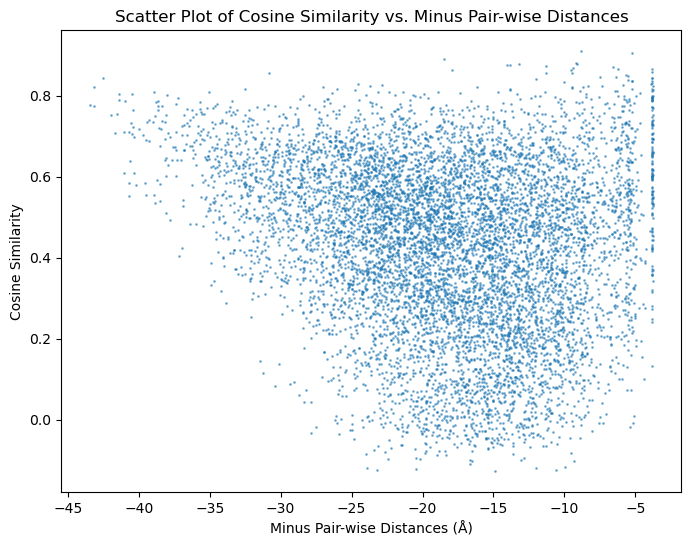

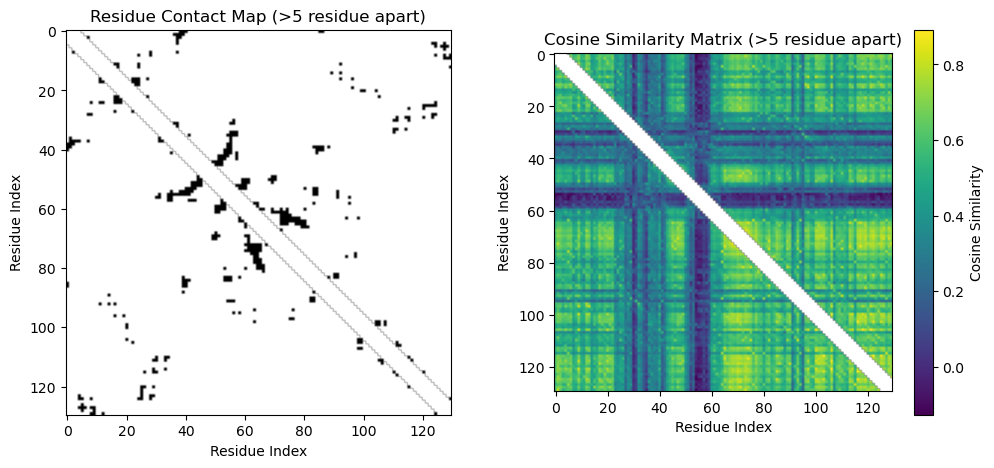

In [ ]:
minus_dist_flat, _ = flatten_upper(-dist_matrix)
cos_sim_flat, _ = flatten_upper(cos_sim)
# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(minus_dist_flat, cos_sim_flat, alpha=0.5, s=1)
plt.xlabel("Minus Pair-wise Distances (Å)")
plt.ylabel("Cosine Similarity")
plt.title("Scatter Plot of Cosine Similarity vs. Minus Pair-wise Distances")
plt.show()

# Imshow plots with masking
mask = np.abs(np.subtract.outer(np.arange(len(seq)), np.arange(len(seq)))) < 5
masked_contact_matrix = contact_matrix.astype(float)
masked_contact_matrix[mask] = np.nan
masked_cos_sim = cos_sim.copy()
masked_cos_sim[mask] = np.nan
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(masked_contact_matrix, cmap="Greys")
plt.title("Residue Contact Map (>5 residue apart)")
plt.xlabel("Residue Index")
plt.ylabel("Residue Index")
plt.subplot(1, 2, 2)
plt.imshow(masked_cos_sim, cmap="viridis")
plt.colorbar(label="Cosine Similarity")
plt.title("Cosine Similarity Matrix (>5 residue apart)")
plt.xlabel("Residue Index")
plt.ylabel("Residue Index")
plt.show()

#### 6. Discuss whether the model is good enough to predict 3d structures.

The values from task 3, specifically the ROC-AUC scores are above 0.5, which is what a random classifier would produce.
It is however only around 0.6 which is quite low.

This in combination with the low scores of pearson/spearman correlation, which indicate that two embedding being close only slightly correlates to proximity in the real world, seem to indicate that the model is not good enough for predicting 3d structures.


## Part 2: Predicting variant effects in Lysozyme using model Pseudo-likelihood (3.5 points)

A lot of genetic diseases happen because the DNA is changed in such a way that the resulting protein changes its primary structure (the sequence of amino acids). One way this happens is that the protein becomes unstable or and therfore cannot carry out its function any more. Protein language models, such as ESM-2, are trained on natural proteins which are functional, one would expect that comparing the probabilities (stictly speaking, pseudo-likelihood) of two similar protein sequences under the model would give us insight into their relative function, or stability. In this part we will explore and compare how well the total change in pseudo-log-likelihood compares against the log-odds computed at a given site to predict variant effects with ESM-2.

The log-odds of changing (mutating) a residue $a$ at position $i$ to $b$ is given by:

$
\text{log-odds}(i, a \rightarrow b)
    = \log P\left( X_i = b \mid \mathbf{X}_{\setminus i} \right)
    - \log P\left( X_i = a \mid \mathbf{X}_{\setminus i} \right)
$

where $\mathbf{X}_{\setminus i} = \text{all residues in } \mathbf{X} \text{ except position } i$. The pseudo-log-likelihood (PLL) of a sequence $\mathbf{x}=\{x_i\}_{i=1}^L$ is instead given by:

$
\text{PLL}(\mathbf{x}) = \sum_{i=1}^{L} \log P \left( X_i = x_i \mid \mathbf{X}_{\setminus i} \right)
$

We can use the PLL expression to compare a sequence to one with a mutant, by taking a difference.

**Tasks:**

Your task is to implement a function that computes the **pseudo-log-likelihood** (PLL) of a protein sequence by masking each position and letting the ESM model predict its original amino acid.

Fill in the missing code sections of the function below by following the **step-by-step tasks and hints**.

### 1. c Complete function template (2p)

Copy the template below into a code cell and complete it.

```python
def compute_pseudo_loglik(sequence, model, alphabet, device, batch_size=130):
    """
    Compute pseudo-log-likelihood for the input sequence using the ESM model.

    Returns:
        log_probs (array): Per-residue log-likelihoods.
        total (float): Sum of log-likelihood over the sequence.
    """

    # Set model to evaluation mode
    model = model.eval()

    # Convert sequence to tokens using alphabet.get_batch_converter()
    _, _, tokens = alphabet.get_batch_converter()([('seq', sequence)])

    # Move tokens to device (CPU/GPU)
    tokens = tokens.to(device)

    # TASK 4: Initialize array to store per-position log probabilities
    # Hint: Use numpy zeros of length L
    L = len(sequence)


    # TASK 5: Get mask token index from alphabet
    # Hint: There's an alphabet attribute mask_idx

    # TASK 6: Create a list of positions to mask
    # Hint: Attention – ESM indexing starts at 1 (position 0 is CLS, short for classification)

    # TASK 7: Loop over positions in batches
    # Hint: Use range(0, L, batch_size)

    # TASK 8: For each batch, duplicate sequence tokens
    # Hint: Use tokens.repeat(number_of_positions, 1).clone()

    # TASK 9: Apply mask at the appropriate position in each sequence
    # Hint: batch[j, pos] = mask_idx

    # TASK 10: Run the model forward pass
    # Hint use model(batch, repr_layers=[], return_contacts=False)

    # TASK 11: Compute log-softmax over logits
    # Hint: Use torch.log_softmax(logits[j, pos], dim=-1)

    # TASK 12: Get the probability of the correct amino acid
    # Hint: true_idx = tokens[0, pos]

    # TASK 13: Store result in log_probs

    # TASK 14: Sum all log_probs to get total pseudo likelihood

    # Return log_probs and total
    return log_probs, total

# compute all pseudo-likelihoods and total log-pseudo-likelihood
plog, total_log = compute_pseudo_loglik(seq, model, alphabet, DEVICE, batch_size=32)

```

### 2. Compute variant effects of Lysozyme disease variants

Tasks:

1. **w** A scientific paper by Peyps and co-workers from 1993 describes two mutants of lysozyme which are associated with a disease. Look the up here: [https://pubmed.ncbi.nlm.nih.gov/8464497/](https://pubmed.ncbi.nlm.nih.gov/8464497/). (0.25p)
2. **c** Use your completed `compute_pseudo_loglik` function to compute the `total_log` of these mutants and compare it to the `total_log` of the wildtype sequence (`seq`), (hint: use mutant minus wildtype -> ΔPLL). (0.25p)
3. **c** Generate 16 random mutations and compare their `total_log` to the wildtype. (0.25p)
4. **c** Use the supplied `compute_log_odds_mutation` function to compute the change in log-odds of mutation of the disease and random mutants. (0.15p)
5. **w** Compare and discuss the results. Were the disease mutations significantly different from the random background? (0.3p)
6. **w** Does your results give you a reliable the usefulness of language models for variant interpretation — or does it say something deeper about mutation biology? Discuss. (0.3p)


In [61]:
def compute_pseudo_loglik(sequence, model, alphabet, device, batch_size=130):
    """
    Compute pseudo-log-likelihood for the input sequence using the ESM model.

    Returns:
        log_probs (array): Per-residue log-likelihoods.
        total (float): Sum of log-likelihood over the sequence.
    """

    # Set model to evaluation mode
    model = model.eval()

    # Convert sequence to tokens using alphabet.get_batch_converter()
    _, _, tokens = alphabet.get_batch_converter()([("seq", sequence)])

    # Move tokens to device (CPU/GPU)
    tokens = tokens.to(device)

    # TASK 4: Initialize array to store per-position log probabilities
    # Hint: Use numpy zeros of length L
    L = len(sequence)
    log_probs = np.zeros(L)

    # TASK 5: Get mask token index from alphabet
    # Hint: There's an alphabet attribute mask_idx
    mask_idx = alphabet.mask_idx

    # TASK 6: Create a list of positions to mask
    # Hint: Attention – ESM indexing starts at 1 (position 0 is CLS, short for classification)
    positions = list(range(1, L + 1))

    # TASK 7: Loop over positions in batches
    # Hint: Use range(0, L, batch_size)
    for i in range(0, L, batch_size):
        batch_positions = positions[i : i + batch_size]
        batch_size_actual = len(batch_positions)

        # TASK 8: For each batch, duplicate sequence tokens
        # Hint: Use tokens.repeat(number_of_positions, 1).clone()
        # Create a batch tensor by duplicating tokens for each position in the batch
        batch = tokens.repeat(batch_size_actual, 1).clone()

        # TASK 9: Apply mask at the appropriate position in each sequence
        # Hint: batch[j, pos] = mask_idx
        for j, pos in enumerate(batch_positions):
            batch[j, pos] = mask_idx

        # TASK 10: Run the model forward pass
        # Hint use model(batch, repr_layers=[], return_contacts=False)
        with torch.no_grad():
            logits = model(batch, repr_layers=[], return_contacts=False)["logits"]

        # TASK 11: Compute log-softmax over logits
        # Hint: Use torch.log_softmax(logits[j, pos], dim=-1)
        for j, pos in enumerate(batch_positions):
            log_probs_all = torch.log_softmax(logits[j, pos], dim=-1)

            # TASK 12: Get the probability of the correct amino acid
            # Hint: true_idx = tokens[0, pos]
            true_idx = tokens[0, pos]

            # TASK 13: Store result in log_probs
            log_probs[pos - 1] = log_probs_all[true_idx].item()

    # TASK 14: Sum all log_probs to get total pseudo likelihood
    total = np.sum(log_probs)

    # Return log_probs and total
    return log_probs, total


# compute all pseudo-likelihoods and total log-pseudo-likelihood
plog, total_log = compute_pseudo_loglik(seq, model, alphabet, DEVICE, batch_size=32)
print("Total pseudo-log-likelihood:", total_log)


Total pseudo-log-likelihood: -235.980970099743


In [8]:
import torch
import numpy as np


def compute_log_odds_mutation(sequence, pos0, mutant_aa, model, alphabet, device):
    """
    Compute log-odds mutation effect at a single position based on masked prediction.

    Args:
        sequence (str): Wild-type protein sequence (no special tokens).
        pos0 (int): 0-based position of mutation in original sequence.
        mutant_aa (str): Single-letter code of mutant amino acid (e.g., "A").
        model: ESM model from ESM-2.
        alphabet: Alphabet object from ESM-2.
        device: 'cpu' or 'cuda'.

    Returns:
        log_odds (float): log(P(mut | rest)) - log(P(wt | rest)).
    """

    model.eval()
    batch_converter = alphabet.get_batch_converter()
    _, _, tokens = batch_converter([("id", sequence)])
    tokens = tokens.to(device)

    # Position in token space (1-based since 0 is CLS)
    pos_token = pos0 + 1

    with torch.no_grad():
        # Create masked input
        batch = tokens.clone()
        batch[0, pos_token] = alphabet.mask_idx

        # Forward pass
        out = model(batch, repr_layers=[], return_contacts=False)
        logits = out["logits"]  # (1, seq_len, vocab_size)

        # Softmax over amino acid logits at masked position
        logp = torch.log_softmax(logits[0, pos_token], dim=-1)

        # Indices of wildtype and mutant amino acids
        wt_idx = tokens[0, pos_token]  # original AA index
        mut_idx = alphabet.get_idx(mutant_aa)

        log_wt = logp[wt_idx].cpu().item()
        log_mut = logp[mut_idx].cpu().item()

    return log_mut - log_wt
